<a href="https://colab.research.google.com/github/hanyoseob/lecture_optimization/blob/main/chapter13_Performance_evaluation_for_super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performace evaluation for super resolution
---
Until now, we have learned various optimization methods such as [a gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent), [a newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), and [a conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method).

Here, we will compare a deblurring performance accoding to the optimization methods.

Its optimization problem is formulated as:

> $x^* = \arg \min_{x} F(x)$,

where a fidelity term $F(x)$ is defined as $\frac{1}{2} || Ax - y ||_2^2$, a system matrix $A$ denotes 2D convolution operation with Gaussian kernel, $y$ is blurry image from the system matrix $A$, and $x$ is a deblurred image.


## Optimization methods
---
1. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
3. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

###[Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
---
> $x_{n+1} = x_n - \lambda_n \nabla F(x_n)$,

where $F(\cdot)$ and $\nabla F(\cdot)$ are any objective function and its derivative function, respectively, and $\lambda_n$ is step size.


###[Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
---
> $x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$,

where $f(\cdot)$ and $f'(\cdot)$ are the function trying to find the roots ( or zeros ) and its derivative, respectively.

###[Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
---
Suppose we want to solve the system of linear equations
> $Ax=b$,

for the vector $x$, where the known $n \times n$ matrix $A$ is symmetric (i.e., $A^T = A$), positive-definite (i.e., $x^TAx > 0$ for all non-zero vectors $x \in \mathbb{R}^n$), and real, and $b$ is known as well. We denote the unique solution of this system by $x^*$.

> $r_0 := b - Ax_0$
>
> if $r_0$ is sufficiently small, then return $x_0$ as the result
>
> $p_0 := r_0$
> 
> k := 0
> 
> repeat
>
>> $a_k := \frac{r_k^Tr_k}{p_k^TAp_k}$
>> 
>> $x_{k+1} := x_k + \alpha_kp_k$
>>
>> $r_{k+1} := r_k - \alpha_kAp_k$
>>
>> if $r_{k+1}$ is sufficiently small, then exit loop
>>
>> $\beta_k := \frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}$
>>
>> $p_{k+1} := r_{k+1} + \beta_k p_k$
>>
>> k := k + 1
>
> end repeat
>
> return $x_{k+1}$ as the result

# Implementation
---

1. Problem definition
2. Functionalization of optimization methods
3. Execution of optimization methods

## Problem definition
---
1. Objective function $F(x)$
> $F(x) = \frac{1}{2} || Ax - y ||_2^2$

2. its derivative $\nabla F(x)$
> $\nabla F(x) = A^T(Ax - y)$


##Execution of optimization methods
---
1. Add packages
2. Define 2D [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)
3. Set Set the system matrix $A$ and its transpose $A^T$
4. Define the optimization methods
5. Run the optimization methods

### Add packages

In [ ]:
# Mathmetical packages
import numpy as np
from scipy.signal import convolve

# Image processing package
from skimage import data
from skimage.transform import resize

# Metrics calculating packages
from skimage.metrics import normalized_root_mse as compare_nmse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ploting packages
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# Ploting options
font = {'family': 'normal',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)


### Define [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)

> $f(x, y) = A \exp \left( -{\left( {\frac{(x - x_0)^2}{2\sigma_X^2}} + {\frac{(y - y_0)^2}{2\sigma_Y^2}} \right)} \right),$

where $A$ is the amplitude, $x_0$ and $y_0$ are the center positions, $\sigma_X$ and $\sigma_Y$ are the standard deviations.

In [ ]:
def gaus2d(nx, ny, x0=0, y0=0, sgmx=3, sgmy=3, A=1):

    x = np.linspace(-nx/2, nx/2, nx)
    y = np.linspace(-ny/2, ny/2, ny)
    x, y = np.meshgrid(x, y)

    ker = A * np.exp(-(0.5*((x - x0)/sgmx)**2 + 0.5*((y - y0)/sgmy)**2))
    ker = ker / np.sum(ker)

    return ker


### Set the system matrix $A$ and its transpose $A^T$

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


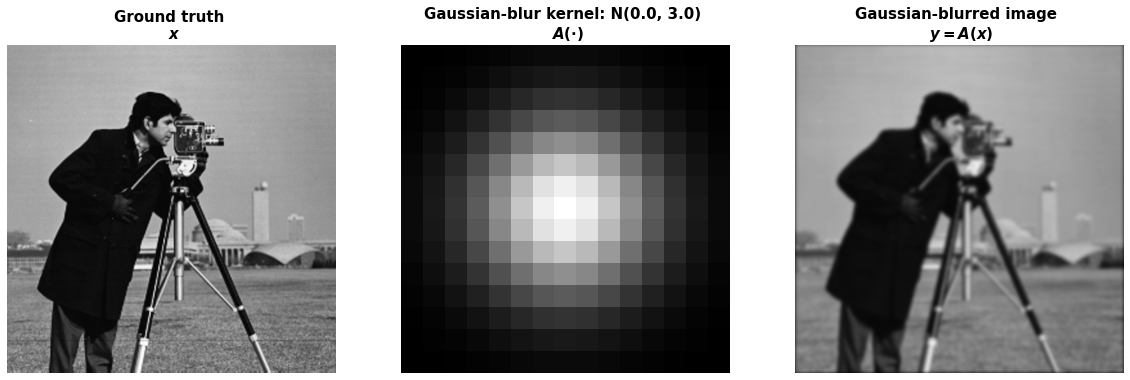

Result from Gaussian-blurred
NSME: 1.1977e-01
PSNR: 24.0498
SSIM: 0.8574
 


In [ ]:
# Load the clean image x ( = ground truth ) 
N = 512   # number of rows for the image
M = 512   # number of colums for the image

x_gt = data.camera().astype(dtype=np.float64)/255.0
x_gt = resize(x_gt, output_shape=(N, M))

# Generate Gaussian kernel A
K = 15    # size of the Gaussian kernel (*the size of kernel must be matched with 'ODD NUMBER'.)
MEAN = 0  # mean of Gaussian kernel
SGM = 3   # standard deviation of Gaussian kernel

ker = gaus2d(K, K, x0=MEAN, y0=MEAN, sgmx=SGM, sgmy=SGM)

# Define the System operator (A) and its transpose (AT)
# A: Convolution operation with Gaussian kernel
# AT: Convolution operation with fliped Gaussian kernel
A = lambda x: convolve(x, ker, mode='same')
AT = lambda y: convolve(y, np.flip(np.flip(ker, axis=0), axis=1), mode='same')

# Generate the output y from the system operator A
y = A(x_gt)


# Plot the images
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

axs[0].imshow(x_gt, vmin=0, vmax=1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Ground truth \n $x$', fontsize=15, fontweight='bold')

axs[1].imshow(ker, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Gaussian-blur kernel: N(%.1f, %.1f) \n $A( \cdot )$' % (MEAN, SGM), fontsize=15, fontweight='bold')

axs[2].imshow(y, vmin=0, vmax=1, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Gaussian-blurred image \n $y = A(x)$', fontsize=15, fontweight='bold')

plt.show()

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_gaus = y

nmse_gaus = compare_nmse(x_gt, x_gaus)
psnr_gaus = compare_psnr(x_gt, x_gaus)
ssim_gaus = compare_ssim(x_gt, x_gaus)

print('Result from Gaussian-blurred')
print('NSME: %.4e' % nmse_gaus)
print('PSNR: %.4f' % psnr_gaus)
print('SSIM: %.4f' % ssim_gaus)
print(' ')

### Define the optimization methods
---
1. Set the general parameters
2. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
3. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
4. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

####Set the general parameters
---

In [ ]:
# F: Objective function
# dF: Its derivative
F = lambda x: 1/2 * np.sum( (A(x) - y) ** 2 ) ** 1/2
dF = lambda x: AT( A(x) - y )

# The number of iterations
max_iter = 300

####[Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
---

In [ ]:
# Hyper parameters for the gradient descent method
step_size_gd = 1e-1

In [ ]:
def gradient_descent_method(x, dF, F, step_size=1e-1, max_iter=100, is_figure=False):
  y_iter = []

  for i in range(1, max_iter + 1):

    # Grdient descent method
    x = x - step_size * dF(x)

    y_iter.append(F(x))

    # Plot the results from gradient descent method
    if is_figure and ((i + 1) % 10) == 0 or (i + 1) == max_iter:
      # Plot the result from gradient descent method
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
      ax = axs[0]
      pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
      ax.set_title('%d-th result from gradient descent method' % (i + 1), fontsize=15, fontweight='bold')
      # fig.colorbar(pcm, ax=ax)

      # Plot a curve of the objective function
      ax = axs[1]
      ax.semilogy(y_iter, 'r--', linewidth=3)
      ax.grid(True)
      ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
      # ax.set_ylabel('Objective function', fontsize=15, fontweight='bold')
      ax.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

      display.clear_output(wait=True)
      plt.show()

  return x, y_iter

####[Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
---

In [ ]:
# f: The function trying to find the roots ( or zeros ) ( = dF )
# df: Its derivative
f_newton = lambda x: AT( A(x) - y )
df_newton = lambda x: AT( A(np.ones_like(x)) )


In [ ]:
def newtons_method(x, f, df, F, max_iter=100, is_figure=False):
  y_iter = []

  for i in range(1, max_iter + 1):

    # Newton's method
    x = x - f(x) / df(x)

    y_iter.append(F(x))

    # Plot the results from newton's method
    if is_figure and ((i + 1) % 10) == 0 or (i + 1) == max_iter:
      # Plot the result from newton's method
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
      ax = axs[0]
      pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
      ax.set_title('%d-th result from newton\'s method' % (i + 1), fontsize=15, fontweight='bold')
      # fig.colorbar(pcm, ax=ax)

      # Plot a curve of the objective function
      ax = axs[1]
      ax.semilogy(y_iter, 'r--', linewidth=3)
      ax.grid(True)
      ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
      # ax.set_ylabel('Objective function', fontsize=15, fontweight='bold')
      ax.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

      display.clear_output(wait=True)
      plt.show()

  return x, y_iter

#### [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
---

In [ ]:
# A_cg: The system matrix to apply the conjugate gradient method
# b: Its measurement (CONSTANT VALUES)
A_cg = lambda x: AT( A(x) )
b_cg = AT(y)


In [ ]:
def conjugate_gradient_method(x, A, b, max_iter=100, is_figure=False):
  y_iter = []

  # Search the solution using the conjugate gradient method
  # r = b - np.matmul(A, x)
  r = b - A_cg(x)
  p = r
  # rs_old = np.matmul(r.T, r)
  rs_old = np.matmul(r.reshape(1, -1), r.reshape(-1, 1))

  for i in range(1, max_iter + 1):
    # Ap = np.matmul(A, p)
    Ap = A_cg(p)

    # alpha = rs_old / np.matmul(p.T, Ap)
    alpha = rs_old / (np.matmul(p.reshape(1, -1), Ap.reshape(-1, 1)))
    
    x = x + alpha * p
    r = r - alpha * Ap

    # rs_new = np.matmul(r.T, r)
    rs_new = np.matmul(r.reshape(1, -1), r.reshape(-1, 1))

    if np.sqrt(rs_new) < 1e-10:
      y_iter.append(F(x))
      break

    p = r + (rs_new / rs_old) * p
    rs_old = rs_new

    y_iter.append(F(x))

    # Plot the results from conjugate gradient method
    if is_figure and ((i + 1) % 10) == 0 or (i + 1) == max_iter:
      # Plot the result from newton's method
      fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))
      ax = axs[0]
      pcm = ax.imshow(x, cmap='gray', vmin=0, vmax=1)
      ax.set_title('%d-th result from conjugate gradient method' % (i + 1), fontsize=15, fontweight='bold')
      # fig.colorbar(pcm, ax=ax)

      # Plot a curve of the objective function
      ax = axs[1]
      ax.semilogy(y_iter, 'r--', linewidth=3)
      ax.grid(True)
      ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
      # ax.set_ylabel('Objective function', fontsize=15, fontweight='bold')
      ax.set_title('$x^*$ = arg $\min_x 1/2 || Ax - y ||^2_2$', fontsize=15, fontweight='bold')

      display.clear_output(wait=True)
      plt.show()

  return x, y_iter

### Run the optimization methods
---
1. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
3. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

#### [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)

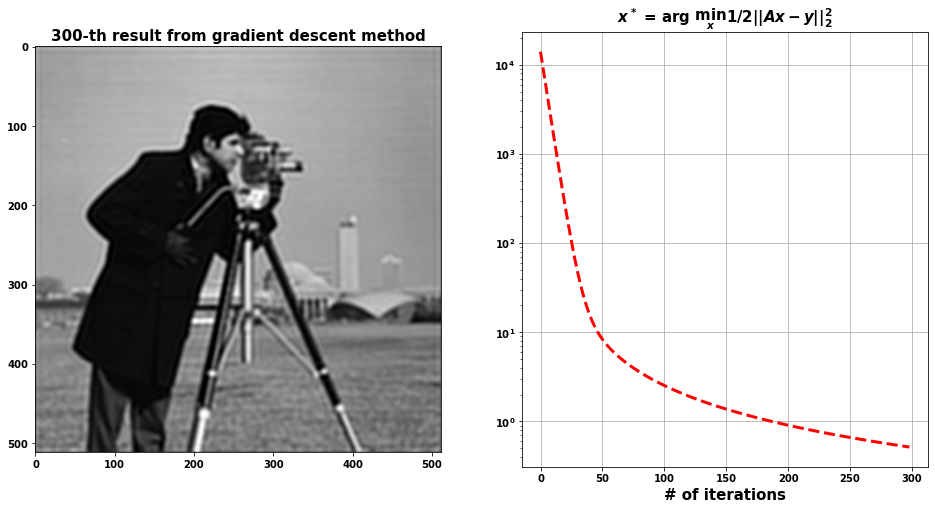

Result from gradient descent method
NSME: 8.0677e-02
PSNR: 27.4814
SSIM: 0.9051


In [ ]:
# Initiate image x
x = np.zeros((N, M))

# Run gradient descent method
x_est_gd, loss_gd = gradient_descent_method(x, dF, F, step_size=step_size_gd, max_iter=max_iter, is_figure=True)

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
nmse_gd = compare_nmse(x_gt, x_est_gd)
psnr_gd = compare_psnr(x_gt, x_est_gd)
ssim_gd = compare_ssim(x_gt, x_est_gd)

print('Result from gradient descent method')
print('NSME: %.4e' % nmse_gd)
print('PSNR: %.4f' % psnr_gd)
print('SSIM: %.4f' % ssim_gd)

#### [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)

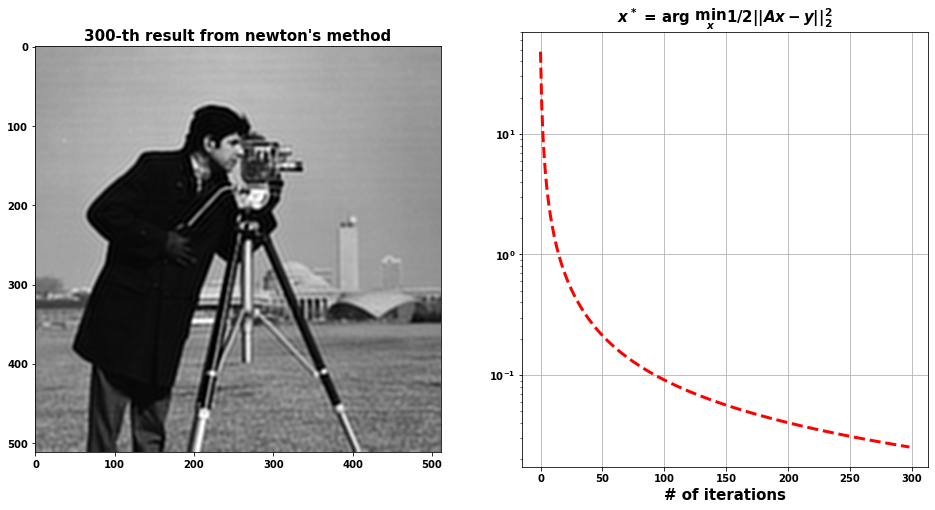

Result from newton's method
NSME: 6.0153e-02
PSNR: 30.0313
SSIM: 0.9429


In [ ]:
# Initiate image x
x = np.zeros((N, M))

# Run Newton's method
x_est_newton, loss_newton = newtons_method(x, f_newton, df_newton, F, max_iter=max_iter, is_figure=True)

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
nmse_newton = compare_nmse(x_gt, x_est_newton)
psnr_newton = compare_psnr(x_gt, x_est_newton)
ssim_newton = compare_ssim(x_gt, x_est_newton)

print('Result from newton\'s method')
print('NSME: %.4e' % nmse_newton)
print('PSNR: %.4f' % psnr_newton)
print('SSIM: %.4f' % ssim_newton)

####  [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)

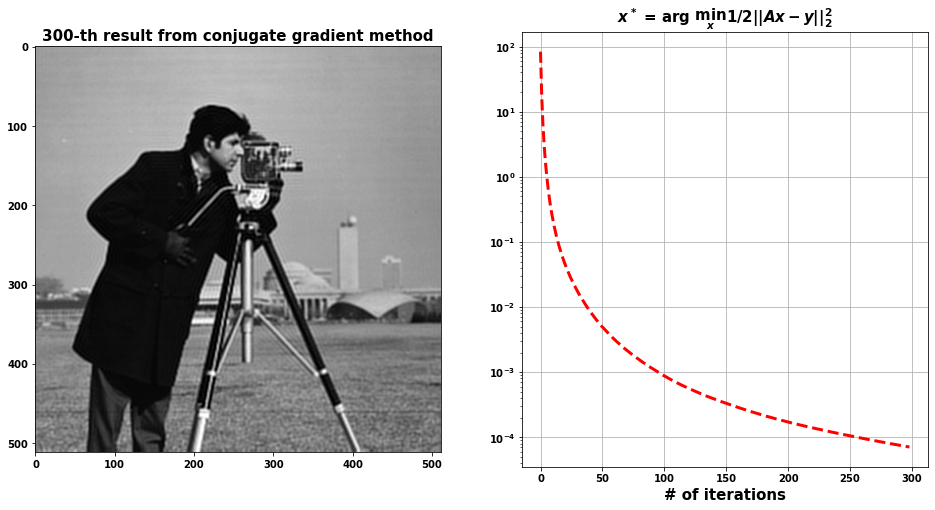

Result from conjugate gradient method
NSME: 3.2555e-02
PSNR: 35.3641
SSIM: 0.9796


In [ ]:
# Initiate image x
x = np.zeros((N, M))

# Run conjugate gradient method
x_est_cg, loss_cg = conjugate_gradient_method(x, A_cg, b_cg, max_iter=max_iter, is_figure=True)

# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
nmse_cg = compare_nmse(x_gt, x_est_cg)
psnr_cg = compare_psnr(x_gt, x_est_cg)
ssim_cg = compare_ssim(x_gt, x_est_cg)

print('Result from conjugate gradient method')
print('NSME: %.4e' % nmse_cg)
print('PSNR: %.4f' % psnr_cg)
print('SSIM: %.4f' % ssim_cg)

# Results
___

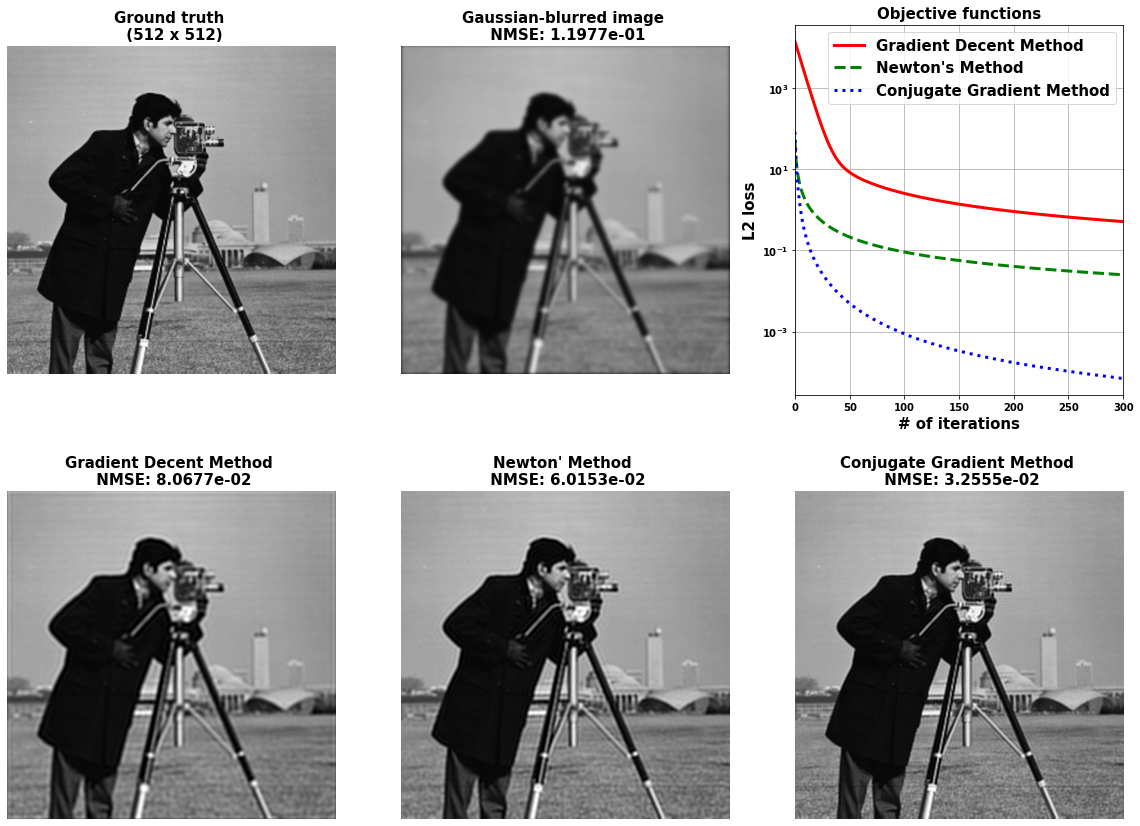

 
Quantitative metrics
 
Normalized  Mean Sqaure Error (NMSE)
Gaussian-blurred           : 1.1977e-01
Gradient descent method    : 8.0677e-02
Newton's method            : 6.0153e-02
Conjugate gradient method  : 3.2555e-02
 
Peak Signal to Noise Ratio (PSNR)
Gaussian-blurred           : 24.0498
Gradient descent method    : 27.4814
Newton's method            : 30.0313
Conjugate gradient method  : 35.3641
 
Structural Similarity Index Measure (SSIM)
Gaussian-blurred           : 0.8574
Gradient descent method    : 0.9051
Newton's method            : 0.9429
Conjugate gradient method  : 0.9796
 


In [ ]:
# Plot the results from gradient descent method, newton's method, and conjugate gradient method
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 15))

ax = axs[0, 0]
ax.imshow(x_gt, vmin=0, vmax=1, cmap='gray')
ax.axis('off')
ax.set_title('Ground truth \n (%d x %d)' % (N, M), fontsize=15, fontweight='bold')

ax = axs[0, 1]
ax.imshow(x_gaus, vmin=0, vmax=1, cmap='gray')
ax.axis('off')
ax.set_title('Gaussian-blurred image \n NMSE: %.4e' % (nmse_gaus), fontsize=15, fontweight='bold')

ax = axs[0, 2]
ax.semilogy(loss_gd, 'r-', label='Gradient Decent Method', linewidth=3)
ax.semilogy(loss_newton, 'g--', label='Newton\'s Method', linewidth=3)
ax.semilogy(loss_cg, 'b:', label='Conjugate Gradient Method', linewidth=3)
ax.legend(fontsize=15)
ax.grid(True)
ax.set_xlim((0, max_iter))
ax.set_xlabel('# of iterations', fontsize=15, fontweight='bold')
ax.set_ylabel('L2 loss', fontsize=15, fontweight='bold')
ax.set_title('Objective functions', fontsize=15, fontweight='bold')


axs[1, 0].imshow(x_est_gd, vmin=0, vmax=1, cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].set_title('Gradient Decent Method \n NMSE: %.4e' % (nmse_gd), fontsize=15, fontweight='bold')

axs[1, 1].imshow(x_est_newton, vmin=0, vmax=1, cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].set_title('Newton\' Method \n NMSE: %.4e' % (nmse_newton), fontsize=15, fontweight='bold')

axs[1, 2].imshow(x_est_cg, vmin=0, vmax=1, cmap='gray')
axs[1, 2].axis('off')
axs[1, 2].set_title('Conjugate Gradient Method \n NMSE: %.4e' % (nmse_cg), fontsize=15, fontweight='bold')

plt.show()

# Print the quantitative metrics
print(' ')
print('Quantitative metrics')
print(' ')

print('Normalized  Mean Sqaure Error (NMSE)')
print('Gaussian-blurred           : %.4e' % nmse_gaus)
print('Gradient descent method    : %.4e' % nmse_gd)
print('Newton\'s method            : %.4e' % nmse_newton)
print('Conjugate gradient method  : %.4e' % nmse_cg)
print(' ')

print('Peak Signal to Noise Ratio (PSNR)')
print('Gaussian-blurred           : %.4f' % psnr_gaus)
print('Gradient descent method    : %.4f' % psnr_gd)
print('Newton\'s method            : %.4f' % psnr_newton)
print('Conjugate gradient method  : %.4f' % psnr_cg)
print(' ')

print('Structural Similarity Index Measure (SSIM)')
print('Gaussian-blurred           : %.4f' % ssim_gaus)
print('Gradient descent method    : %.4f' % ssim_gd)
print('Newton\'s method            : %.4f' % ssim_newton)
print('Conjugate gradient method  : %.4f' % ssim_cg)
print(' ')


# Conclusion

In this chapter, we covered ___the deblurring problem___, which is the ___realistic___ and ___practical___ problems in a natural image processing. Above figures show the results from [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function), [a gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent), [a newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), and [the conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method). Specifically, [the conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) provides an high-enhanced image quality and its quantitative metrics are significantly improved than other methods like [a gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent) and [a newton's method](https://en.wikipedia.org/wiki/Newton%27s_method).

#References
---

1. [Gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent)
2. [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method)
3. [Conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method)
4. [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)


# Next
---

Next chapter, we will summarize all the optimization methods such as the [gradient descent method](https://en.wikipedia.org/wiki/Gradient_descent), [newton's method](https://en.wikipedia.org/wiki/Newton%27s_method), and [conjugate gradient method](https://en.wikipedia.org/wiki/Conjugate_gradient_method), and review their performance through the medical image processing.